In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timedelta
from datetime import datetime
from datetime import timedelta
from time import time
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
register_matplotlib_converters()
from statsmodels.tsa.arima.model import ARIMA

In [9]:
#read data
production_ice_cream=pd.read_csv('ice_cream.csv',parse_dates=[0],index_col=0,date_format='%Y-%m-%d').squeeze()

In [10]:
production_ice_cream.rename('production',inplace=True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [11]:
# infer the frequency of the data
production_ice_cream = production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [12]:
# getting data form 2010 onwards
start_date=pd.to_datetime('2010-01-01')
production_ice_cream  = production_ice_cream[start_date:]

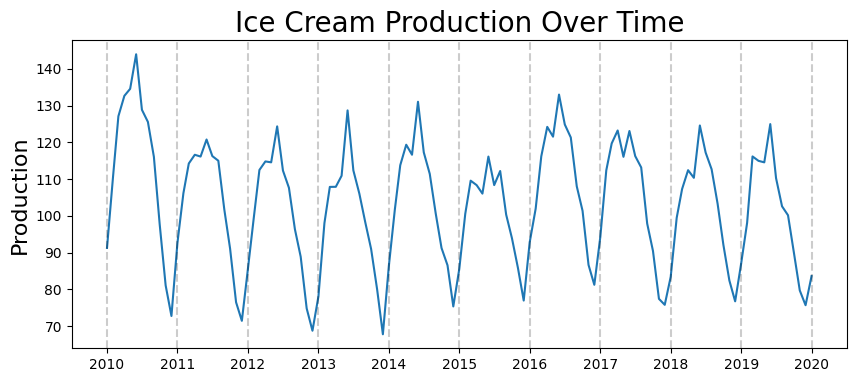

In [13]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice Cream Production Over Time',fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2010,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

In [14]:
train_end = datetime(2016,12,1)
test_end  = datetime(2019,12,1)
train_data = production_ice_cream[:train_end]
test_data = production_ice_cream[train_end + timedelta(days=1):test_end]

In [15]:
model = ARIMA(train_data,order=(3,0,0))

In [16]:
# fir the model
start=time()
model_fit = model.fit()
end=time()
print('Model fitting Time:',end-start)

Model fitting Time: 0.07290196418762207


In [17]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                   84
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -294.008
Date:                Sat, 09 Mar 2024   AIC                            598.015
Time:                        00:04:29   BIC                            610.169
Sample:                    01-01-2010   HQIC                           602.901
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5071      2.531     40.893      0.000      98.546     108.468
ar.L1          1.0488      0.116      9.046      0.000       0.822       1.276
ar.L2         -0.0532      0.204     -0.260      0.7

In [18]:
# get prediction start and end date
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [19]:
# get predictions and residuals
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

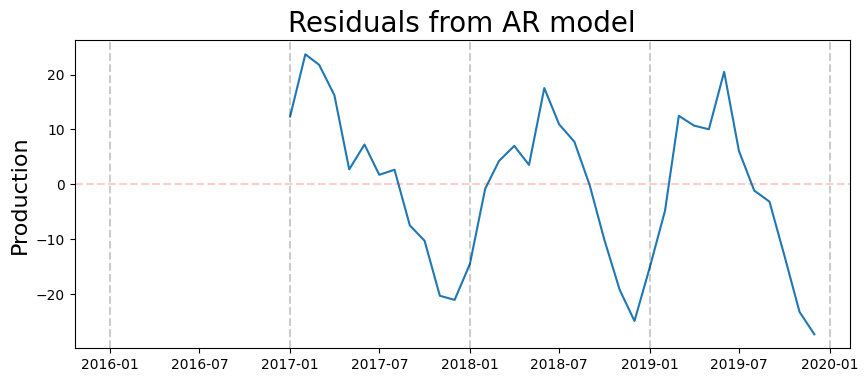

In [22]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Production',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2016,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

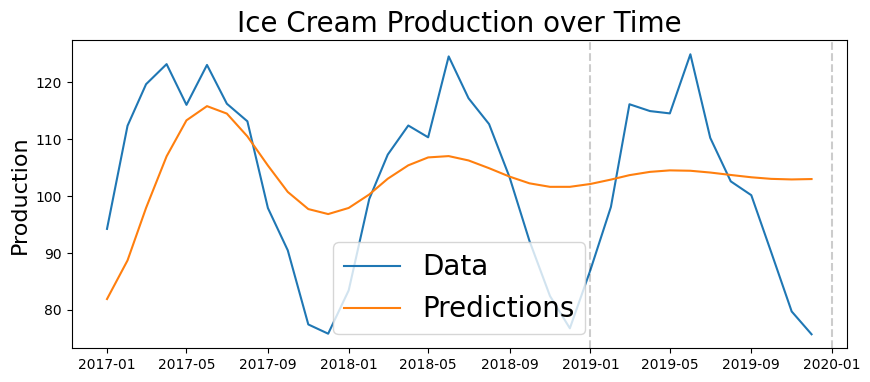

In [21]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'),fontsize=20)

plt.title('Ice Cream Production over Time',fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

We can see that as we are trying to predict more into the future, the predictions are getting less accurate and converging towards mean

In [23]:
print('Mean Absolute Percent Error:',np.mean(abs(residuals/test_data)))

Mean Absolute Percent Error: 0.12110226446972633


In [24]:
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 13.890102343815379


# Rolling Forecast Origin
<b> Idea: Predict one month in advance each time</b> \
<i>Train on months 1,2,.....,k-3->predict month k-2</i> \
<i>Train on months 1,2,.....,k-3,k-2->predict month k-1</i> \
<i>Train on months 1,2,.....,k-3,k-2,k-1->predict month k</i> \
....... \
Average all predictions

In [25]:
# create the model 
predictions_rolling = pd.Series()
# why series?-Each element in the Series can be labeled with a unique index, which can be any hashable data type.
for end_date in test_data.index:
    train_data = production_ice_cream[:end_date-timedelta(days=1)]
    model = ARIMA(train_data, order=(3,0,0))
    model_fit = model.fit()
    pred = model_fit.predict(end_date)
    predictions_rolling.loc[end_date]=pred.loc[end_date]


In [26]:
residuals_rolling= test_data-predictions_rolling

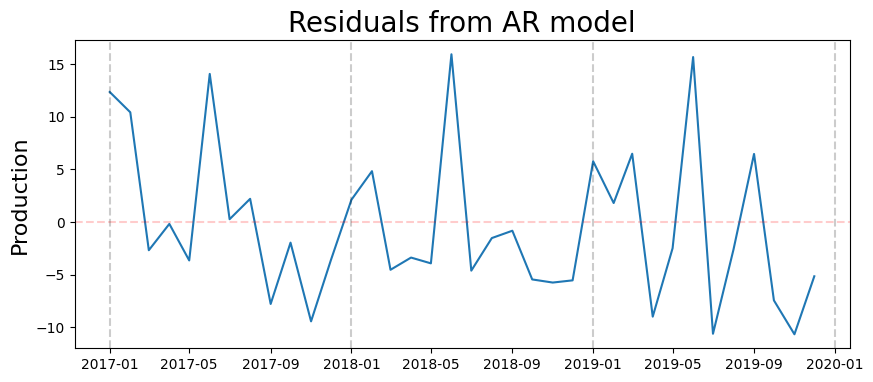

In [29]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR model',fontsize=20)
plt.ylabel('Production',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2017,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)

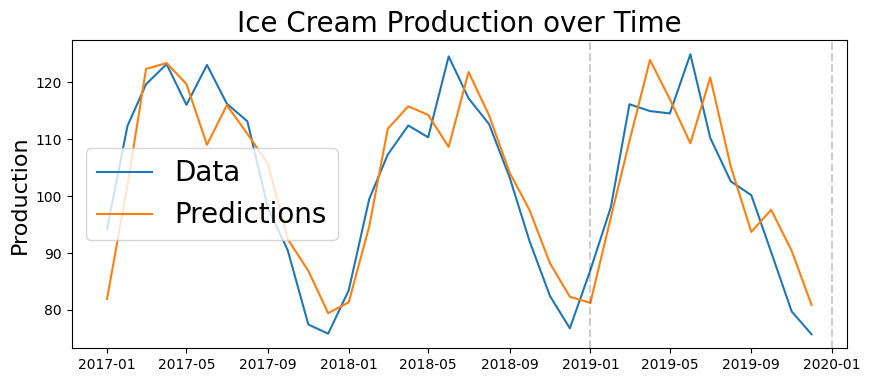

In [30]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)
plt.legend(('Data','Predictions'),fontsize=20)

plt.title('Ice Cream Production over Time',fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='k',linestyle='--',alpha=0.2)